#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from keras.layers import Dense, Flatten, Activation, Lambda, Cropping2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D, AveragePooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import glob
%matplotlib inline

Using TensorFlow backend.


### Import Vehicle and Non-Vehicle Images
As deep neural networks need more data. We are augmenting data by Flipping Vehicle images vertically while flipping non-Vehicle images Vertically and Horizontally.

In [2]:
imagesVehiclePath = glob.glob('Vehicles/vehicles/*/*.png')
nonImagesVehiclePath = glob.glob('non-Vehicles/non-vehicles/*/*.png')
vehicle = []
nonVehicle = []
for imgPath in imagesVehiclePath:
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vehicle.append(img)
    vehicle.append(cv2.flip(img, 1)) #Flipping Horizontally

for imgPath in nonImagesVehiclePath:
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    nonVehicle.append(img)
    nonVehicle.append(cv2.flip(img, 1)) #Flipping Horizontally
    nonVehicle.append(cv2.flip(img, 0)) #Flipping Vertically

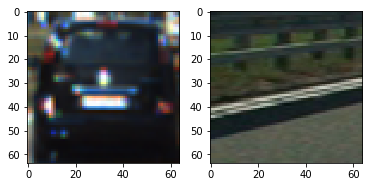

In [3]:
plt.subplot(121)
plt.imshow(vehicle[np.random.randint(0, len(vehicle))])

plt.subplot(122)
plt.imshow(nonVehicle[np.random.randint(0, len(nonVehicle))])

### Generating Labels
Generating the Labels of Vehicles and Non-Vehicles images by taking vehicles as 1 and non-vehicles as 0.

In [4]:
y_label_class = [1,0]
y_label_vehicle = [y_label_class[0]]*len(vehicle)
y_label_nonVehicle = [y_label_class[1]]*len(nonVehicle)

data = np.vstack([vehicle, nonVehicle])
label = np.hstack([y_label_vehicle, y_label_nonVehicle])

In [5]:
print("Number of total Vehicle Images", len(vehicle))
print("Number of total non Vehicle Images", len(nonVehicle))
print("Number of total Input Data", len(data))

Number of total Vehicle Images 17584
Number of total non Vehicle Images 26904
Number of total Input Data 44488


### Using generator

In [6]:
# GENERATOR WILL LOAD THE IMAGES FROM DATA IN BATCHES RETURN IT TO THE MODEL FOR TRAINING
def generator(images_data, measurement_data, batch_size=32):
    num_samples = len(images_data)
    while 1:
        shuffle(images_data, measurement_data)
        for offset in range(0, num_samples, batch_size):
            batch_images = []
            batch_images_path = []
            batch_images_path = np.array(images_data[offset: offset + batch_size])
            batch_measurements = np.array(measurement_data[offset: offset + batch_size])
            
            for img in batch_images_path:
                batch_images.append(img)
            
            flipped_img = np.concatenate((batch_images,np.fliplr(batch_images)))
            flipped_measurement = np.concatenate((batch_measurements, (batch_measurements*(-1))))
            
            yield shuffle(flipped_img, flipped_measurement)
#SPLITTING DATA IN TRAINING AND TESTING
X_train, X_valid,y_train, y_valid = train_test_split(data, label, test_size = 0.2)

train_generator = generator(X_train, y_train, batch_size = 64)
valid_generator = generator(X_valid, y_valid, batch_size = 32)

### DECLARING MODEL
Used RELU in the final layer as RELU will give the output between 0 and 1 while sigmoid will return probability. With RELU we are getting better results compared to sigmoid.

In [7]:
#DECLARE THE MODEL
print("Declaring Model")
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5)-1, input_shape=(64,64,3)))

model.add(Convolution2D(24,5,5, subsample = (2,2), name='Conv1', activation='relu'))
model.add(Convolution2D(36,5,5, subsample = (2,2), name='Conv2', activation='relu'))
model.add(Convolution2D(48,5,5, subsample = (2,2), name='Conv3', activation='relu'))

model.add(Flatten(name='Flat1'))
model.add(Dropout(0.2, name='Drop2'))
model.add(Dense(100, name='Dense1', activation='relu'))          
model.add(Dense(50, name='Dense2', activation='relu'))
model.add(Dropout(0.2, name='Drop3'))
model.add(Dense(10, name='Dense3', activation='relu'))
model.add(Dense(1, activation='relu', name='Output_Layer'))

print("Model Declared")
model.summary()

Declaring Model
Model Declared
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 30, 30, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 13, 13, 36)    21636       Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 5, 5, 48)      43248       Conv2[0][0]                      
____________________________________________________________

Compiling Model

In [8]:
model.compile(loss='mse', optimizer= Adam(lr = 0.0001))
model.fit_generator(train_generator, samples_per_epoch=len(X_train),validation_data= valid_generator, nb_val_samples=len(X_valid), nb_epoch=6)

Epoch 1/6
35584/35590 [============================>.] - ETA: 0s - loss: 0.3059

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


35712/35590 [==============================] - 15s - loss: 0.3057 - val_loss: 0.2530
Epoch 2/6
35596/35590 [==============================] - 10s - loss: 0.2496 - val_loss: 0.2364
Epoch 3/6
35712/35590 [==============================] - 10s - loss: 0.2308 - val_loss: 0.2258
Epoch 4/6
35596/35590 [==============================] - 10s - loss: 0.2289 - val_loss: 0.2188
Epoch 5/6
35712/35590 [==============================] - 10s - loss: 0.2211 - val_loss: 0.2150
Epoch 6/6
35596/35590 [==============================] - 10s - loss: 0.2208 - val_loss: 0.2146


Save the Model for predicting Vehicles.

In [9]:
model.save('model_Relu.h5')

Visualizing the Features learned by the 

In [10]:
# visualize model layers output
from keras import backend as K
layerOutput = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[2].output])
idx = 5000 
testLabel = label[idx]

image = data[idx]
layerOutputSample = layerOutput([image.reshape(1,image.shape[0],image.shape[1],image.shape[2]), 1])[0]
layerOutputSample = layerOutputSample.reshape(layerOutputSample.shape[1],layerOutputSample.shape[2],layerOutputSample.shape[3])

Feature Matrix of CNN


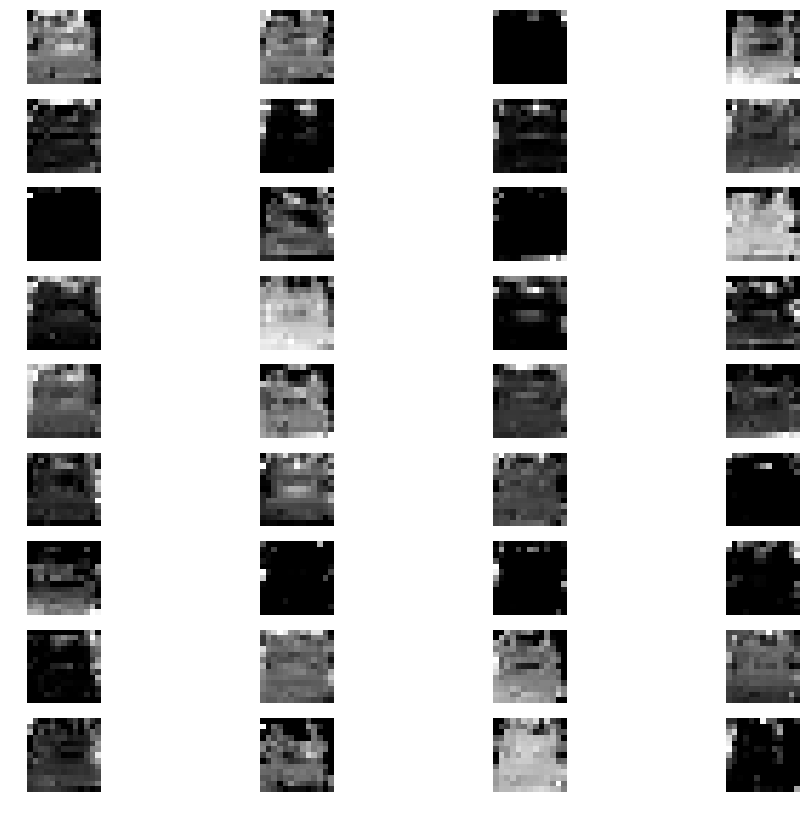

In [11]:
print("Feature Matrix of CNN")
figure = plt.figure(figsize=(16,16))
factors = [10,4]
for ind in range(layerOutputSample.shape[2]):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    #plt.subplot(4, 4, ind + 1)
    val = layerOutputSample[:,:,ind]
    plt.axis("off")
    plt.imshow(val, cmap='gray',interpolation='nearest')